## An introduction to XGBoost regression
- https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.17</div>
<div style="text-align: right"> Last update: 2023.7.17</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import xgboost as xgb
print(xgb.__version__)

1.7.5


In [3]:
train = pd.read_csv("../data/house-price/train.csv", index_col=0)
test = pd.read_csv("../data/house-price/test.csv", index_col=0)

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# 여기서는 편의를 위해 수치형 데이터만 다룸
X_train = train.select_dtypes(include=['number']).copy()
X_train = X_train.drop(['SalePrice'], axis=1)
y_train = train["SalePrice"]
X_test  = test.select_dtypes(include=['number']).copy()

피처 추가

In [6]:
for df in (X_train, X_test):
    df["n_bathrooms"] = df["BsmtFullBath"] + (df["BsmtHalfBath"]*0.5) + df["FullBath"] + (df["HalfBath"]*0.5)
    df["area_with_basement"]  = df["GrLivArea"] + df["TotalBsmtSF"]

xgboost 모델

In [7]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor = xgb.XGBRegressor(
    eval_metric = "rmsle"
)

In [8]:
regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

In [10]:
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

In [11]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


베스트 파라미터로 재학습

In [12]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

feature importance

In [13]:
from xgboost import plot_importance

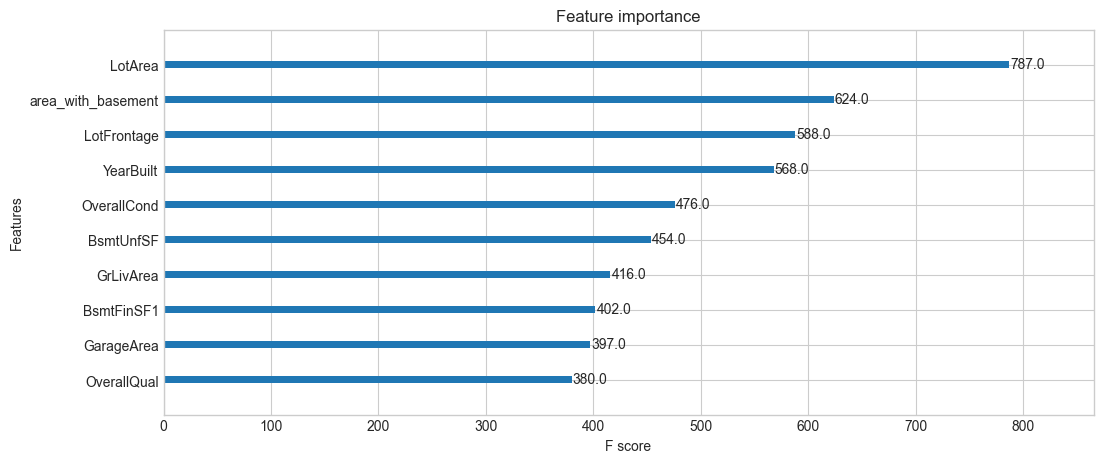

In [14]:
fig, ax = plt.subplots(figsize = (12, 5))
plot_importance(regressor, max_num_features=10, ax = ax)
plt.show()